# Analysis of the factors defining the price of a car

## Business understanding
When buying a car every client faces the problem that the prices differ strongly even in the same category of vehicles. So what is causing that variance?<br/>
<br/>
Today’s market offers an enormous variety. The vehicles themselves have become a complex technical systems containing multiple subsystems which offer different features. Additionally there is a possibility for customization of some of those by the client. On top of that we need to consider also the advertising campaigns and the reputation some manufacturers have.<br/>
<br/>
Though there is a huge varienty of features in a car, there are some basic ones, which are valid for both old and new models. Their effect on the price will be analyzed in this post. We will try to find the answers of the following three questions:<br/>
- Which factors or features are mainly influencing the price of car?
- How much does the manufacturer's name/brand effect the end price of a car?
- What should the price of a conventional middle class family car be according to the model created?

## Data undestanding

In [196]:
# Import python libraries/modules required for the initial data analysis
import pandas as pd
pd.set_option('max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [197]:
# Check the columns in the data set and get an initial notion of the datatypes in each one
df = pd.read_csv('data.csv')
df.head()


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [198]:
df.shape

(11914, 16)

The used data has been taken from kaggle (https://www.kaggle.com/CooperUnion/cardataset) and comprizes car prices from year 1990 to 2017. There are overall 16 columns and 11914 rows containing both numrical and categorical data.<br/>

The target variable (column of interest) is the 'MSRP' which contains the price of the car. The goal of this analysis is to find out what is the dependence of that column on the rest in the dataset. Thus we can make an estimation about the factors defining the price and about the extend of that influence.

#### Check column data information
Begin the initial data analysis by checking the amount of unique and missing data in the separate columns. For that purpose define a function that scans the number of missing data in the respective column and outputs the results as an absolute value and a percentile.

In [199]:
%pip install beautifultable
from beautifultable import BeautifulTable

Note: you may need to restart the kernel to use updated packages.


In [200]:
def print_column_data_information(df):
    """Print names of columns with respective information regarding
    number of unique values and missing data. The data is printed in
    a tabular format.
    Please note that 'beautifultable' is required to be installed for
    that.

    Args:
        df (pandas Dataframe): Dataframe whose columns are examined
    """
    n_all = df.shape[0]
    table = BeautifulTable()
    table.columns.header = ["Column", "Num unique", "Type", "Num missing", "Perc missing"]
    for col in df.columns:
        sum_na = df[col].isna().sum()
        table.rows.append([col, df[col].nunique(), df[col].dtypes, sum_na, 100*sum_na/n_all])
    print(table)

In [201]:
print_column_data_information(df)

+-------------------+------------+---------+-------------+--------------+
|      Column       | Num unique |  Type   | Num missing | Perc missing |
+-------------------+------------+---------+-------------+--------------+
|       Make        |     48     | object  |      0      |     0.0      |
+-------------------+------------+---------+-------------+--------------+
|       Model       |    915     | object  |      0      |     0.0      |
+-------------------+------------+---------+-------------+--------------+
|       Year        |     28     |  int64  |      0      |     0.0      |
+-------------------+------------+---------+-------------+--------------+
| Engine Fuel Type  |     10     | object  |      3      |    0.025     |
+-------------------+------------+---------+-------------+--------------+
|     Engine HP     |    356     | float64 |     69      |    0.579     |
+-------------------+------------+---------+-------------+--------------+
| Engine Cylinders  |     9      | flo

From the first look of the data the following can be noted:
- 'Market Category' column has a lot of missing data, so propabla needs to be removed
- 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders' and 'Number of Doors' have some missing data, so an imputation could be considered
- 'Model' column which is of type 'object' has many unique values and thus inappropriate to process in a ML model
- The meaning of 'Popularity' column is not clear and most importantly how that index is calculated, so it will not be considered further.

## Data Processing
As can be seen 'Market Category' column is missing almost 1/3 of the data, so it would be appropriate to drop the whole column. For the rest of the cases there is less than 1% missing, so an imputation could be implemented.

In [202]:
df = df.drop('Market Category', axis=1, errors='ignore')

#### Impute missing values
For the coulumns 'Engine Fuel Type', 'Engine HP', 'Engine Cylinders' and 'Number of Doors' we can impute values where they are missing. For that purpose we will use the rest of the dataset and some of the vehicle characteristics as a comparison/condition when choosing the value to impute.

In [203]:
# Check 'Engine Fuel Type' missing entries
df[df['Engine Fuel Type'].isna()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
11321,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,Midsize,Sedan,25,17,481,17199
11322,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,Midsize,Sedan,25,17,481,20199
11323,Suzuki,Verona,2004,NaN,155.0,6.0,AUTOMATIC,front wheel drive,4.0,Midsize,Sedan,25,17,481,18499


The 'Engine Fuel Type' to be imputed will be chosen comparing engine characteristics of other vehicle entries and taking the most common one.<br/>
- Define a 10% upper and lower limit of the engine horse power
- Choose the same numer of engine cylinders<br/>

After implementing the filters above, take the value for 'Engine Fuel Type' with the highest frequency

In [204]:
def gen_imp_value_eng_fuel_type(df):
    """Function to generate/filter the value to be imputed in the place of 
    missing data for 'Engine Fuel Type'

    Args:
        df (pandas Dataframe): Dataframe whose columns are examined
    
    Returns:
        (object): Engine fuel type sulting from the filter process
    """
    return df[(df['Engine HP'] > 0.9*155.0) & (df['Engine HP'] < 1.1*155.0) &\
        (df['Engine Cylinders'] == 6)]['Engine Fuel Type'].value_counts()\
            .sort_values().index[-1]

In [205]:
imp_value = gen_imp_value_eng_fuel_type(df)
df['Engine Fuel Type'] = df['Engine Fuel Type'].fillna(imp_value)

In [206]:
# Check 'Number of Doors' missing entries
df[df['Number of Doors'].isna()]


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
4666,Ferrari,FF,2013,premium unleaded (required),651.0,12.0,AUTOMATED_MANUAL,all wheel drive,NaN,Large,Coupe,16,11,2774,295000
6930,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,Large,Sedan,105,102,1391,79500
6931,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,Large,Sedan,101,98,1391,66000
6932,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,Large,Sedan,105,92,1391,134500
6933,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,rear wheel drive,NaN,Large,Sedan,100,97,1391,74500
6934,Tesla,Model S,2016,electric,NaN,0.0,DIRECT_DRIVE,all wheel drive,NaN,Large,Sedan,107,101,1391,71000


The 'Number of Doors' missing values will be imputed. Vehicle characteristics to be used as a comparison arguments:
- Vehicle Size
- Vehicle Style

Out of the filetered entries the most frequent will be taken and imputed in place of the missing number of doors.

In [207]:
def gen_imp_value_num_doors(df, ind):
    """Generate an imputation value for the missing number of
    doors data.

    Args
        df (pandas Dataframe): Dataframe whose columns are examined
        ind (int): Index of the row with 'Number of Doors' missing
    
    Returns:
        (int): Number of doors to be imputed for the relevant row index
    """
    veh_size = df.iloc[ind]['Vehicle Size']
    veh_style = df.iloc[ind]['Vehicle Style']
    # Compare vehicles from the dataset with the same parameters
    return df[(df['Vehicle Size'] == veh_size) & \
        (df['Vehicle Style'] == veh_style)]['Number of Doors'].value_counts().\
            sort_values().index[-1]

In [208]:
# List with indexes of the rows with missing number of doors
list_index_miss_door = df[df['Number of Doors'].isna()].index
for i in list_index_miss_door:
    imp_value = gen_imp_value_num_doors(df, i)
    df.at[i,'Number of Doors'] = imp_value

In [209]:
# Check 'Engine HP' missing entries
df[df['Engine HP'].isna()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
539,FIAT,500e,2015,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,108,122,819,31800
540,FIAT,500e,2016,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
541,FIAT,500e,2017,electric,NaN,0.0,DIRECT_DRIVE,front wheel drive,2.0,Compact,2dr Hatchback,103,121,819,31800
2905,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,all wheel drive,4.0,Large,Sedan,25,17,61,55915
2906,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,front wheel drive,4.0,Large,Sedan,27,18,61,62915
2907,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,front wheel drive,4.0,Large,Sedan,27,18,61,53915
2908,Lincoln,Continental,2017,premium unleaded (recommended),NaN,6.0,AUTOMATIC,all wheel drive,4.0,Large,Sedan,25,17,61,64915
4203,Ford,Escape,2017,regular unleaded,NaN,4.0,AUTOMATIC,front wheel drive,4.0,Compact,4dr SUV,30,23,5657,29100
4204,Ford,Escape,2017,regular unleaded,NaN,4.0,AUTOMATIC,all wheel drive,4.0,Compact,4dr SUV,28,22,5657,30850
4205,Ford,Escape,2017,regular unleaded,NaN,4.0,AUTOMATIC,all wheel drive,4.0,Compact,4dr SUV,28,22,5657,26850


In [210]:
# Print proportions of na for electric and non-electric vehicles
print('Engine HP statistic of na')
print('Electric proportion na:', df[df['Engine Fuel Type'] == 'electric']['Engine HP'].isna().mean().round(4))
print('Non-electric proportion na:', df[df['Engine Fuel Type'] != 'electric']['Engine HP'].isna().mean().round(4))

Engine HP statistic of na
Electric proportion na: 0.6667
Non-electric proportion na: 0.0021


It can be seen that almost 67% of the electrical vehicles are missing engine power information. So we will replace those 'NaN' with '0'. On the other hand there are 0.2% of the conventional internal combustion engine vehicles with missing engine power data. For those we can compare their 'engine cylinders' and 'vehicle size', as those two parameters are connected to the engine power. Than we can tale the most frequent value and impute it.

In [211]:
def gen_imp_value_eng_power(df, ind):
    """Generate a value to be imputed in place of the
    missing engine horse power.

    Args
        df (pandas Dataframe): Dataframe whose columns are examined
        ind (int): Index of the row with 'Engine HP' missing
    
    Returns:
        (int): Number of doors to be imputed for the relevant row index
    """
    fuel_type = df.iloc[ind]['Engine Fuel Type']
    veh_size = df.iloc[ind]['Vehicle Size']
    cylinders = df.iloc[ind]['Engine Cylinders']
    eng_hp = 0
    # Compare vehicles from the dataset with the same parameters if NOT electric
    if fuel_type != 'electric':
        eng_hp = df[(df['Vehicle Size'] == veh_size) & \
            (df['Engine Cylinders'] == cylinders)]['Engine HP'].value_counts().\
            sort_values().index[-1]
    return eng_hp

In [212]:
# Impute values for missing 'Engine HP'
list_index_miss_eng_power = df[df['Engine HP'].isna()].index
for i in list_index_miss_eng_power:
    imp_value = gen_imp_value_eng_power(df, i)
    # Update the values
    df.at[i,'Engine HP'] = imp_value

In [213]:
# Check 'Engine Cylinders' missing data
df[df['Engine Cylinders'].isna()]

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
1983,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,110,128,1385,40905
1984,Chevrolet,Bolt EV,2017,electric,200.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,110,128,1385,36620
3716,Volkswagen,e-Golf,2015,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,105,126,873,33450
3717,Volkswagen,e-Golf,2015,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,105,126,873,35445
3718,Volkswagen,e-Golf,2016,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,105,126,873,28995
3719,Volkswagen,e-Golf,2016,electric,115.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Compact,4dr Hatchback,105,126,873,35595
5778,Mitsubishi,i-MiEV,2014,electric,0.0,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Compact,4dr Hatchback,99,126,436,22995
5779,Mitsubishi,i-MiEV,2016,electric,66.0,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Compact,4dr Hatchback,99,126,436,22995
5780,Mitsubishi,i-MiEV,2017,electric,66.0,NaN,DIRECT_DRIVE,rear wheel drive,4.0,Compact,4dr Hatchback,102,121,436,22995
8373,Toyota,RAV4 EV,2012,electric,154.0,NaN,DIRECT_DRIVE,front wheel drive,4.0,Midsize,4dr SUV,74,78,2031,49800


In [214]:
# Print proportions of na for electric and non-electric vehicles
print('Engine Cylinders statistic of na')
print('Electric proportion na:', df[df['Engine Fuel Type'] == 'electric']['Engine Cylinders'].isna().mean().round(4))
print('Non-electric proportion na:', df[df['Engine Fuel Type'] != 'electric']['Engine Cylinders'].isna().mean().round(4))

Engine Cylinders statistic of na
Electric proportion na: 0.1515
Non-electric proportion na: 0.0017


Looking at the data, it can be seen that most electric vehicles have 'Engine Cylinders' 0. The imputation for conventional vehicles will be done using a 10% range around the engine power as a comparison parameter and taking the most frequent value.

In [215]:
def gen_imp_value_eng_cyl(df, ind):
    """Generate an imputation value for the missing number of
    engine cylinders.

    Args
        df (pandas Dataframe): Dataframe whose columns are examined
        ind (int): Index of the row with 'Engine Cylinder' missing
    
    Returns:
        (int): Number of cylinders to be imputed for the relevant row index
    """
    fuel_type = df.iloc[ind]['Engine Fuel Type']
    eng_hp = df.iloc[ind]['Engine HP']
    eng_cyl = 0
    # Compare vehicles from the dataset with the same parameters if electric
    if fuel_type != 'electric':
        eng_cyl = df[(df['Engine HP'] >= 0.9*eng_hp) & \
            (df['Engine HP'] <= 1.1*eng_hp)]['Engine Cylinders'].value_counts().\
            sort_values().index[-1]
    return eng_cyl

In [216]:
# Impute values for missing 'Engine Cylinders'
list_index_miss_eng_cyl = df[df['Engine Cylinders'].isna()].index
for i in list_index_miss_eng_cyl:
    imp_value = gen_imp_value_eng_cyl(df, i)
    # Update the values
    df.at[i,'Engine Cylinders'] = imp_value

Additionally we need to replace the values denoted with 'UNKNOWN' in the feature 'Transmission type'. The choice of 'Transmission Type' will be done using a 10% range around the engine power and vehicle size as a comparison parameter and taking the most frequent value.

In [217]:
print(df['Transmission Type'].value_counts())

AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: Transmission Type, dtype: int64


In [218]:
def gen_repl_value_trans_type(df, ind):
    """Choose a replacement value for the unknown
    transmission type.

    Args
        df (pandas Dataframe): Dataframe whose columns are examined
        ind (int): Index of the row with 'Transmission Type' Unknown
    
    Returns:
        (obj): Transmission type to replace uknown value with
    """
    eng_hp = df.iloc[ind]['Engine HP']
    veh_size = df.iloc[ind]['Vehicle Size']
    return df[((df['Engine HP'] >= 0.9*eng_hp) & \
            (df['Engine HP'] <= 1.1*eng_hp)) & (df['Vehicle Size'] == veh_size) ]['Transmission Type']\
                .value_counts().sort_values().index[-1]

In [219]:
# Replace 'UNKNOWN' value in the 'Transmission Type' column
list_index_trans_type_unknown = df[df['Transmission Type'] == 'UNKNOWN'].index
for i in list_index_trans_type_unknown:
    repl_value = gen_repl_value_trans_type(df, i)
    # Update the value
    df.at[i,'Transmission Type'] = repl_value

In [220]:
# Check whether there are still some missing values after the imputation
df.isna().sum().sort_values()

Make                 0
Model                0
Year                 0
Engine Fuel Type     0
Engine HP            0
Engine Cylinders     0
Transmission Type    0
Driven_Wheels        0
Number of Doors      0
Vehicle Size         0
Vehicle Style        0
highway MPG          0
city mpg             0
Popularity           0
MSRP                 0
dtype: int64

In [221]:
df = df.drop_duplicates()

#### Check outliers
Outliers in the numerical data are not desired as they are causing distortion. That is why we need to see whether there are outliers and if so remove them from the data. 

In [222]:
df.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11194.000000,11194.00000,11194.000000,11194.000000,11194.000000,11194.000000,11194.000000,1.119400e+04
mean,2010.715026,252.38610,5.658299,3.454172,26.610238,19.732089,1557.964445,4.193329e+04
std,7.226875,110.99491,1.803934,0.872922,8.979206,9.179458,1445.449268,6.154731e+04
min,1990.000000,0.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.159925e+04
50%,2015.000000,237.00000,6.000000,4.000000,25.000000,18.000000,1385.000000,3.067500e+04
75%,2016.000000,303.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.303875e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


As can be seen from the output above, in many of the columns there are huge differences between the 75-th percentile and the maximum value for the column. This implies there are outliers. Print boxplots to display them better.

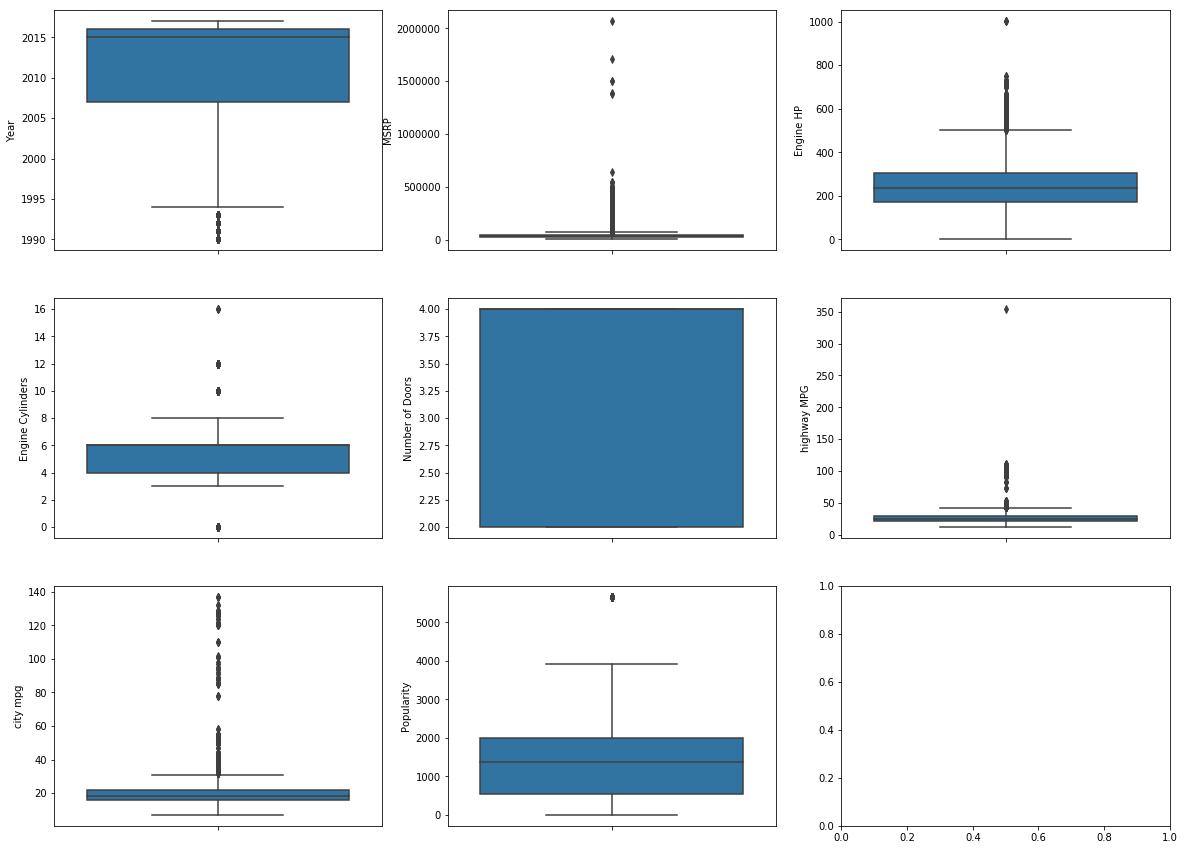

In [223]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

sns.boxplot(ax=axes[0][0], data=df, y='Year')
sns.boxplot(ax=axes[0][1], data=df, y='MSRP')
sns.boxplot(ax=axes[0][2], data=df, y='Engine HP')

sns.boxplot(ax=axes[1][0], data=df, y='Engine Cylinders')
sns.boxplot(ax=axes[1][1], data=df, y='Number of Doors')
sns.boxplot(ax=axes[1][2], data=df, y='highway MPG')

sns.boxplot(ax=axes[2][0], data=df, y='city mpg')
sns.boxplot(ax=axes[2][1], data=df, y='Popularity')

The graphical interpretation makes it even easier to spot the outliers. In dealing with them we will use the inter-quartile-range(IQR). For that purpose we will define a function which cuts entries lying under or above a range defined using the IQR.

In [224]:
# Create list with names of columns with outliers
list_column_outliers = ['Year', 'MSRP', 'Engine HP', 'Engine Cylinders', 'highway MPG', 'city mpg', 'Popularity']

In [225]:
def remove_outliers(dataframe, column_list):
    """Remove outliers from the dataset

    Args:
        dataframe (pandas Dataframe): Dataframe to remove outliers from
        column_list (list): List with names of the columns to remove outliers from

    Returns:
        (pandas Dataframe): Dataframe with removed outliers
    """
    df_no_outlier = dataframe
    for column in column_list:
        Q1 = df_no_outlier[column].quantile(0.25)
        Q3 = df_no_outlier[column].quantile(0.75)

        IQR = Q3 - Q1

        min = Q1 - 1.5*IQR
        max = Q3 + 1.5*IQR

        df_no_outlier = df_no_outlier[(df_no_outlier[column] > min) & (df_no_outlier[column] < max)]

    return df_no_outlier

In [226]:
# Remove outliers
df = remove_outliers(df, list_column_outliers)

In [227]:
# Check data after removing the outliers
df.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,8532.000000,8532.000000,8532.000000,8532.000000,8532.000000,8532.000000,8532.000000,8532.000000
mean,2011.247421,236.366268,5.400961,3.548172,26.523324,19.296531,1202.706751,31102.217300
std,6.315511,76.462370,1.384786,0.821497,5.536130,4.192387,865.565557,15190.265345
min,1994.000000,66.000000,3.000000,2.000000,13.000000,10.000000,21.000000,2000.000000
25%,2007.750000,173.000000,4.000000,4.000000,23.000000,16.000000,535.000000,22000.750000
50%,2015.000000,230.000000,6.000000,4.000000,26.000000,19.000000,1013.000000,30020.000000
75%,2016.000000,290.250000,6.000000,4.000000,30.000000,22.000000,1851.000000,40107.500000
max,2017.000000,469.000000,8.000000,4.000000,44.000000,30.000000,3916.000000,75300.000000


Now lets see what is the price distribution for the different vehicle manufacturers.

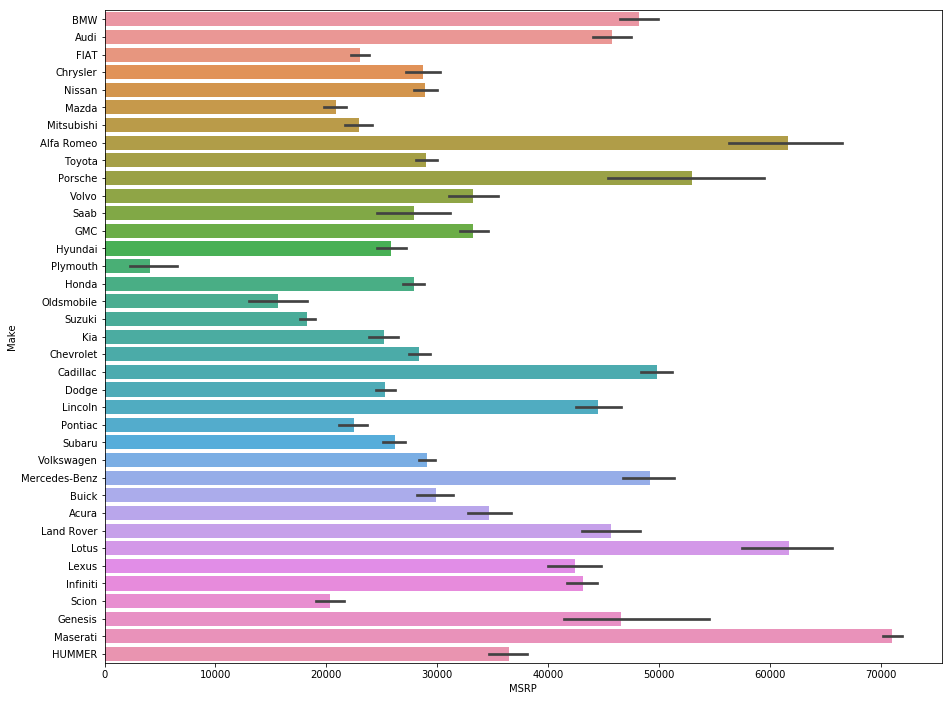

In [228]:
plt.figure(figsize=(15,12))
sns.barplot(data=df, y = "Make", x = "MSRP")

From the diagramm above it is clear that there is a big deviation in the mean prices for the different car makers. It is also clear that there is an enormous deviation in the prices for the same manufacturer(e.g. 'Genesis', 'Porsche', 'Alfa Romeo' and 'Lotus').<br/>
As the number of different vehicle manufacturers is big, it would be inappropriate to directly encode that categorical variable as part of the data preparation for modelling. That is why firstly we will cluster the prices and afterwards we will assign each car maker to a specific price cluster/group.

In [229]:
def cluster_array(lst, n):
    """Create clusters out of the array.

    Args:
        lst (pandas Series): Series with prices/car makers be clustered
        n (int): Number of standard deviations to be used as a distance

    Returns:
        (list): List containing the price groups
        (list): List containing the make groups
    """    
    array_sorted = np.sort(lst.tolist())
    # List of lists containing the clustered entries
    list_clusters = []
    list_clusters_names = []

    clust_ind = 0
    while len(array_sorted) > 0:
        curr_cluster = []
        curr_cluster_names = []
        used_ind = []
        for i in range(len(array_sorted)):
            # The first two values are going directly in
            if len(curr_cluster) <= 1:    
                curr_cluster.append(array_sorted[i])
                curr_cluster_names.append(lst[lst == array_sorted[i]].index.tolist()[0])
                used_ind.append(i)
                continue
            mean = np.mean(curr_cluster)
            stdev = np.std(curr_cluster)
            # Check the "distance"
            if abs(mean - array_sorted[i]) > n * stdev:
                break
            curr_cluster.append(array_sorted[i])
            curr_cluster_names.append(lst[lst == array_sorted[i]].index.tolist()[0])
            used_ind.append(i)

        list_clusters.append(curr_cluster)
        list_clusters_names.append(curr_cluster_names)

        clust_ind += 1
        # Remove the list entries, that are already clustered
        array_sorted = np.delete(array_sorted, used_ind)

    return list_clusters, list_clusters_names

In [230]:
# Create list with prices to be used for cluster creation
list_prices = df.groupby('Make')['MSRP'].mean().round(2)
list_prices.index.tolist()[0]

'Acura'

In [231]:
# Create clusters with prices
list_clusters, list_clusters_names = cluster_array(list_prices, 2)

table = BeautifulTable()
table.columns.header = ["Cluster id", "Cluster prices", "Make"]

for i in range(len(list_clusters)):
    table.rows.append([i, list_clusters[i], list_clusters_names[i]])
print(table)

+------------+-------------------------------+---------------------------------+
| Cluster id |        Cluster prices         |              Make               |
+------------+-------------------------------+---------------------------------+
|     0      | [4141.35, 15632.2, 18266.18,  | ['Plymouth', 'Oldsmobile', 'Suz |
|            | 20347.69, 20830.67, 22521.07, | uki', 'Scion', 'Mazda', 'Pontia |
|            |  22922.27, 23008.7, 25185.62, | c', 'Mitsubishi', 'FIAT', 'Kia' |
|            |  25336.38, 25816.33, 26161.46 | , 'Dodge', 'Hyundai', 'Subaru', |
|            | , 27867.1, 27879.81, 28382.55 |  'Honda', 'Saab', 'Chevrolet',  |
|            | , 28723.66, 28928.48, 29011.7 | 'Chrysler', 'Nissan', 'Toyota', |
|            | 5, 29060.68, 29915.74, 33249. |  'Volkswagen', 'Buick', 'Volvo' |
|            | 01, 33261.4, 34663.45, 36464. |   , 'GMC', 'Acura', 'HUMMER']   |
|            |              41]              |                                 |
+------------+--------------

In [232]:
def assign_group(make, name_cluster):
    """Select cluster id for the respective car maker

    Args:
        make (str): Make of the car
        name_cluster (list): List with cluster with car makers
    
    Returns:
        (int): Cluster id to be assigned
    """
    retValue = 0
    # Iterate through the clusters
    for i in range(len(name_cluster)):
        # Current cluster range
        curr_clust = name_cluster[i]
        # Check if value within range
        if make in curr_clust:
            retValue = i
            break
    return retValue

In [233]:
df['Make_group'] = df['Make'].apply(assign_group, name_cluster=list_clusters_names)
df.tail(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,Make_group
11901,BMW,Z4,2016,premium unleaded (required),240.0,4.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,34,22,3916,49700,3
11902,BMW,Z4,2016,premium unleaded (required),335.0,6.0,AUTOMATED_MANUAL,rear wheel drive,2.0,Compact,Convertible,24,17,3916,66350,3
11906,Acura,ZDX,2011,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,46020,0
11907,Acura,ZDX,2011,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,56570,0
11908,Acura,ZDX,2011,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,50520,0
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,46120,0
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,56670,0
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,50620,0
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr Hatchback,23,16,204,50920,0
11913,Lincoln,Zephyr,2006,regular unleaded,221.0,6.0,AUTOMATIC,front wheel drive,4.0,Midsize,Sedan,26,17,61,28995,2


In [234]:
df_copy = df

## Data modeling

### Feature selection

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8532 entries, 0 to 11913
Data columns (total 16 columns):
Make                 8532 non-null object
Model                8532 non-null object
Year                 8532 non-null int64
Engine Fuel Type     8532 non-null object
Engine HP            8532 non-null float64
Engine Cylinders     8532 non-null float64
Transmission Type    8532 non-null object
Driven_Wheels        8532 non-null object
Number of Doors      8532 non-null float64
Vehicle Size         8532 non-null object
Vehicle Style        8532 non-null object
highway MPG          8532 non-null int64
city mpg             8532 non-null int64
Popularity           8532 non-null int64
MSRP                 8532 non-null int64
Make_group           8532 non-null int64
dtypes: float64(3), int64(6), object(7)
memory usage: 1.4+ MB


### Numerical features
We will use a correlation table to select features correlating with the target and/or exclude those who have relatively high correlation between themselves.

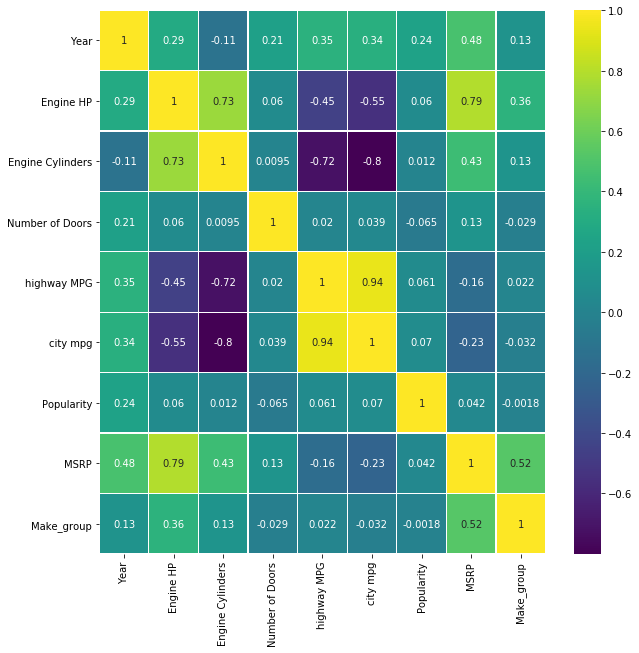

In [236]:
# Let see the correlation of all the features
corr = df.corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='viridis', annot=True, linewidths=0.1)

As can be seen 'Engine Cylinders' has a high correlation with many of the other numerical features, thus it will be excluded. 'highway MPG' and 'city MPG' have also high mutual correlation, so 'highway mpg' will be excluded ('city mpg' has a higher correlation coefficient with the target). 'Popularity' has a relatively small correlation with the target so we will remove it also.

In [237]:
features_num = ['Engine HP', 'Year', 'Number of Doors', 'city mpg']

### Categorical features
Firstly we will put aside the vehicle producer and model, as we want to analyze what features are influencing the price independent of the car make.

In [238]:
# Check the categorical features
df.select_dtypes(include=['object']).head()

,Make,Model,Engine Fuel Type,Transmission Type,Driven_Wheels,Vehicle Size,Vehicle Style
0,BMW,1 Series M,premium unleaded (required),MANUAL,rear wheel drive,Compact,Coupe
1,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Convertible
2,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Coupe
3,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Coupe
4,BMW,1 Series,premium unleaded (required),MANUAL,rear wheel drive,Compact,Convertible


In [239]:
def plot_bar_diagramms_cat_features(df, list_col, target):
    '''Plot bar diagrams for the features in the list_col with y=target

    Args:
        df(pandas DataFrame): Dataframe containing the data
        list_col(list): List with the names of the features to plot bar diagramm for
        target(string): Name of the feature to use as 'y' argument for the barplot
    '''
    num_rows = 1 + len(list_col)//3
    fig, axes = plt.subplots(num_rows, 3, figsize=(num_rows*10, 25))
    i_row = 0
    i_col = 0
    target=target
    for col in list_col:
        feature=str(col)
        sns.barplot(ax=axes[i_row][i_col], data=df, x=feature, y=target).\
            set_xticklabels(labels=df[feature].value_counts().index, rotation=75)
        i_col += 1
        if i_col == 3:
            i_col = 0
            i_row += 1


In [240]:
# List with the names of the features to plot bar diagramm for
list_plot_bar = ['Engine Fuel Type', 'Transmission Type', 'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']

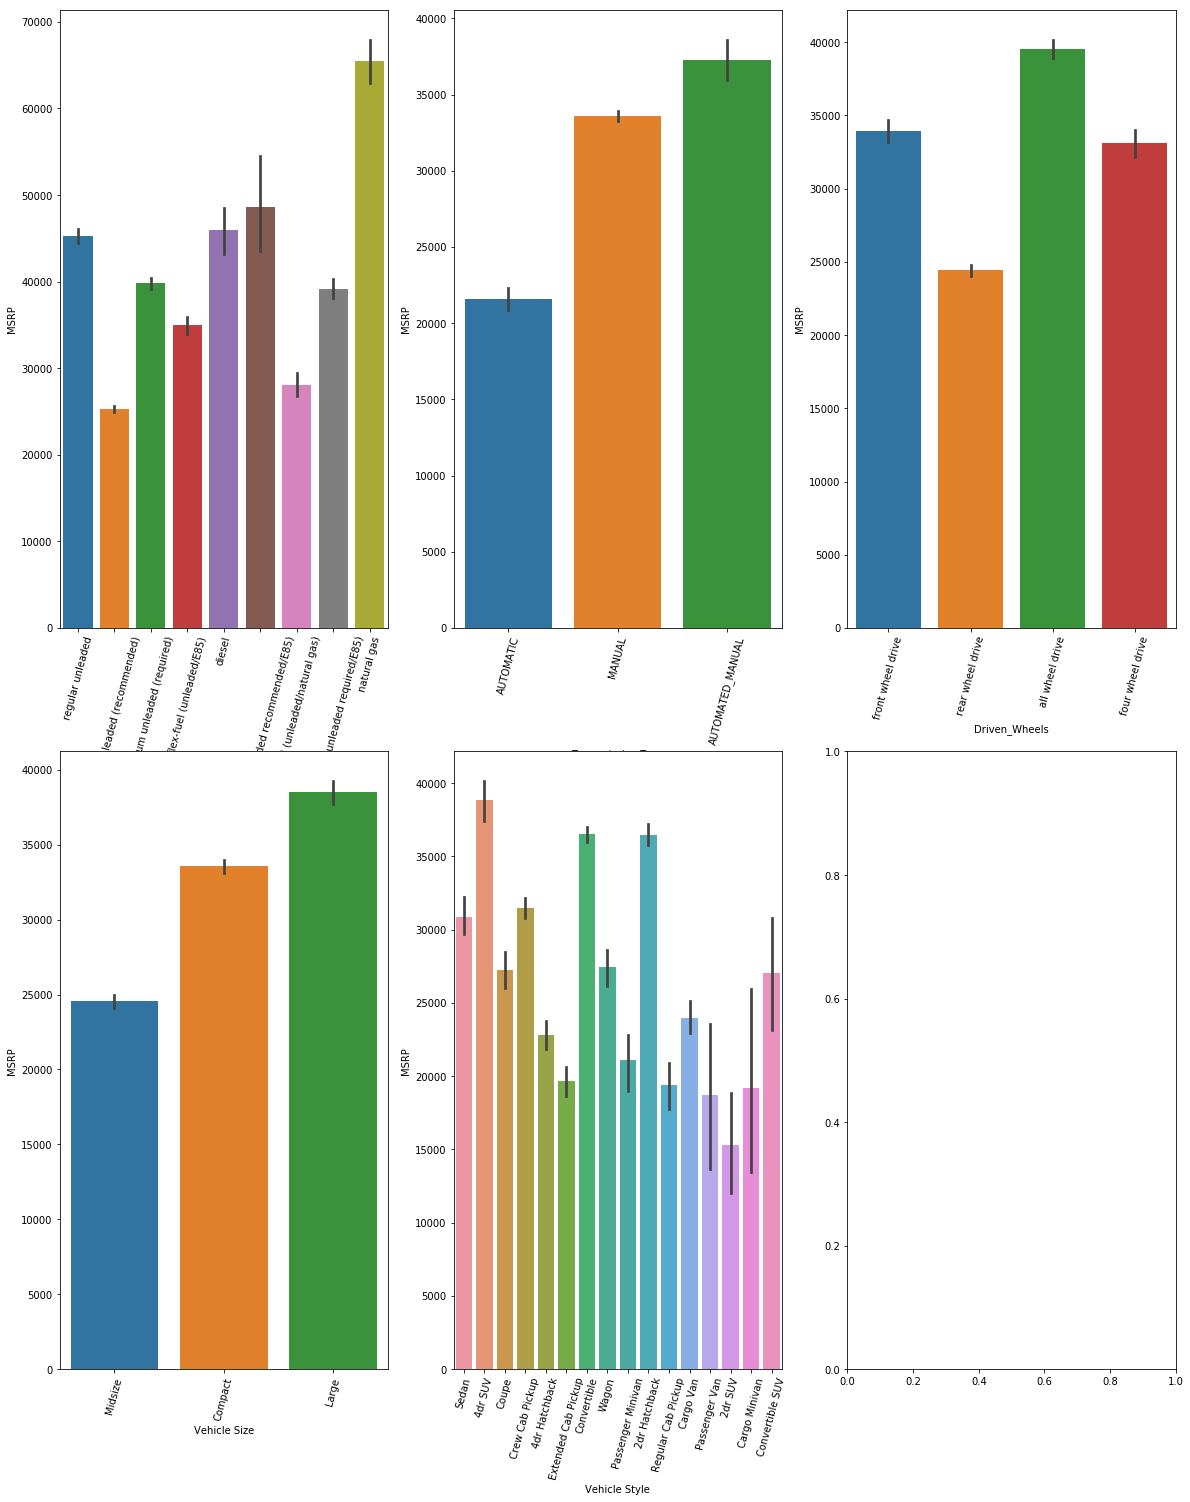

In [241]:
plot_bar_diagramms_cat_features(df, list_plot_bar, 'MSRP')

In [242]:
def create_dummy_df(df, cat_cols, dummy_na=False):
    '''
    Args:
        df - pandas dataframe with categorical variables you want to dummy
        cat_cols - list of strings that are associated with names of the categorical columns
        dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
        
    Returns:
        (pandas DataFrame): Dataframe with encoded categorical variables
    '''
    for col in cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1),pd.get_dummies(df[col], prefix=col, \
                dummy_na=dummy_na, drop_first=True)],axis=1)
        except:
            continue
    return df

In [243]:
# Append the 'Make_group' feature to the list of categorical features to be used by the model
list_plot_bar.append('Make_group')

In [244]:
df = create_dummy_df(df, list_plot_bar)
df.shape

(8532, 46)

In [245]:
df.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP,Engine Fuel Type_flex-fuel (premium unleaded recommended/E85),Engine Fuel Type_flex-fuel (premium unleaded required/E85),Engine Fuel Type_flex-fuel (unleaded/E85),Engine Fuel Type_flex-fuel (unleaded/natural gas),Engine Fuel Type_natural gas,Engine Fuel Type_premium unleaded (recommended),Engine Fuel Type_premium unleaded (required),Engine Fuel Type_regular unleaded,Transmission Type_AUTOMATIC,Transmission Type_MANUAL,Driven_Wheels_four wheel drive,Driven_Wheels_front wheel drive,Driven_Wheels_rear wheel drive,Vehicle Size_Large,Vehicle Size_Midsize,Vehicle Style_2dr SUV,Vehicle Style_4dr Hatchback,Vehicle Style_4dr SUV,Vehicle Style_Cargo Minivan,Vehicle Style_Cargo Van,Vehicle Style_Convertible,Vehicle Style_Convertible SUV,Vehicle Style_Coupe,Vehicle Style_Crew Cab Pickup,Vehicle Style_Extended Cab Pickup,Vehicle Style_Passenger Minivan,Vehicle Style_Passenger Van,Vehicle Style_Regular Cab Pickup,Vehicle Style_Sedan,Vehicle Style_Wagon,Make_group_1,Make_group_2,Make_group_3,Make_group_4,Make_group_5,Make_group_6
0,BMW,1 Series M,2011,335.0,6.0,2.0,26,19,3916,46135,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,BMW,1 Series,2011,300.0,6.0,2.0,28,19,3916,40650,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,BMW,1 Series,2011,300.0,6.0,2.0,28,20,3916,36350,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,BMW,1 Series,2011,230.0,6.0,2.0,28,18,3916,29450,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,BMW,1 Series,2011,230.0,6.0,2.0,28,18,3916,34500,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [246]:
def gather_encoded_features(df, feature_list):
    '''Create a list of features of the dataframe, 
    which are encoded whith a dummy variable.

    Args:
        df (pandas Dataframe): Dataframe to check features from
        feature_list (list): List with features names of the dataframe before encoding
    
    Returns:
        (list): List with names of features which are one-hot-encoded
    '''
    features_cat = []
    for cat_feature in feature_list:
        for col in df.keys():
            if cat_feature in col:
                features_cat.append(col)
    return features_cat

In [247]:
# Gather all encoded feature names of the dataframe
features_cat = []
features_cat = gather_encoded_features(df, list_plot_bar)

### Machine learning modeling

In [248]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [249]:
feature_list_name = features_num + features_cat

In [250]:

X = df[feature_list_name]
y = df['MSRP']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=42)

### ML models

In [251]:
models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L1 Regularization)": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                         Decision Tree": DecisionTreeRegressor(),
    "                         Random Forest": RandomForestRegressor(),
    "                     Gradient Boosting": GradientBoostingRegressor()
}

In [252]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
 Linear Regression (L1 Regularization) trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
                         Random Forest trained.
                     Gradient Boosting trained.


In [253]:
for name, model in models.items():
    print(name + " R^2 Score: {:.5f}".format(model.score(X_test, y_test)))

                     Linear Regression R^2 Score: 0.81840
 Linear Regression (L1 Regularization) R^2 Score: 0.81832
                   K-Nearest Neighbors R^2 Score: 0.90267
                         Decision Tree R^2 Score: 0.93016
                         Random Forest R^2 Score: 0.94449
                     Gradient Boosting R^2 Score: 0.90830


In [254]:
# Print dictionary similar model features
for i in range(len(feature_list_name)):
    print('\'{}\' : [0],'.format(feature_list_name[i]))

'Engine HP' : [0],
'Year' : [0],
'Number of Doors' : [0],
'city mpg' : [0],
'Engine Fuel Type_flex-fuel (premium unleaded recommended/E85)' : [0],
'Engine Fuel Type_flex-fuel (premium unleaded required/E85)' : [0],
'Engine Fuel Type_flex-fuel (unleaded/E85)' : [0],
'Engine Fuel Type_flex-fuel (unleaded/natural gas)' : [0],
'Engine Fuel Type_natural gas' : [0],
'Engine Fuel Type_premium unleaded (recommended)' : [0],
'Engine Fuel Type_premium unleaded (required)' : [0],
'Engine Fuel Type_regular unleaded' : [0],
'Transmission Type_AUTOMATIC' : [0],
'Transmission Type_MANUAL' : [0],
'Driven_Wheels_four wheel drive' : [0],
'Driven_Wheels_front wheel drive' : [0],
'Driven_Wheels_rear wheel drive' : [0],
'Vehicle Size_Large' : [0],
'Vehicle Size_Midsize' : [0],
'Vehicle Style_2dr SUV' : [0],
'Vehicle Style_4dr Hatchback' : [0],
'Vehicle Style_4dr SUV' : [0],
'Vehicle Style_Cargo Minivan' : [0],
'Vehicle Style_Cargo Van' : [0],
'Vehicle Style_Convertible' : [0],
'Vehicle Style_Convertible SU

In [261]:
car = {
'Engine HP' : [140],
'Year' : [2020],
'Number of Doors' : [4],
'city mpg' : [39.2],
'Engine Fuel Type_flex-fuel (premium unleaded recommended/E85)' : [0],
'Engine Fuel Type_flex-fuel (premium unleaded required/E85)' : [0],
'Engine Fuel Type_flex-fuel (unleaded/E85)' : [0],
'Engine Fuel Type_flex-fuel (unleaded/natural gas)' : [0],
'Engine Fuel Type_natural gas' : [0],
'Engine Fuel Type_premium unleaded (recommended)' : [0],
'Engine Fuel Type_premium unleaded (required)' : [0],
'Engine Fuel Type_regular unleaded' : [1],
'Transmission Type_AUTOMATIC' : [0],
'Transmission Type_MANUAL' : [1],
'Driven_Wheels_four wheel drive' : [0],
'Driven_Wheels_front wheel drive' : [1],
'Driven_Wheels_rear wheel drive' : [0],
'Vehicle Size_Large' : [0],
'Vehicle Size_Midsize' : [1],
'Vehicle Style_2dr SUV' : [0],
'Vehicle Style_4dr Hatchback' : [0],
'Vehicle Style_4dr SUV' : [0],
'Vehicle Style_Cargo Minivan' : [0],
'Vehicle Style_Cargo Van' : [0],
'Vehicle Style_Convertible' : [0],
'Vehicle Style_Convertible SUV' : [0],
'Vehicle Style_Coupe' : [0],
'Vehicle Style_Crew Cab Pickup' : [0],
'Vehicle Style_Extended Cab Pickup' : [0],
'Vehicle Style_Passenger Minivan' : [0],
'Vehicle Style_Passenger Van' : [0],
'Vehicle Style_Regular Cab Pickup' : [0],
'Vehicle Style_Sedan' : [1],
'Vehicle Style_Wagon' : [0],
'Make_group_1' : [0],
'Make_group_2' : [0],
'Make_group_3' : [0],
'Make_group_4' : [0],
'Make_group_5' : [0],
'Make_group_6' : [0]
}
df_car = pd.DataFrame.from_dict(car, orient='columns')
df_car.head()

,Engine HP,Year,Number of Doors,city mpg,Engine Fuel Type_flex-fuel (premium unleaded recommended/E85),Engine Fuel Type_flex-fuel (premium unleaded required/E85),Engine Fuel Type_flex-fuel (unleaded/E85),Engine Fuel Type_flex-fuel (unleaded/natural gas),Engine Fuel Type_natural gas,Engine Fuel Type_premium unleaded (recommended),Engine Fuel Type_premium unleaded (required),Engine Fuel Type_regular unleaded,Transmission Type_AUTOMATIC,Transmission Type_MANUAL,Driven_Wheels_four wheel drive,Driven_Wheels_front wheel drive,Driven_Wheels_rear wheel drive,Vehicle Size_Large,Vehicle Size_Midsize,Vehicle Style_2dr SUV,Vehicle Style_4dr Hatchback,Vehicle Style_4dr SUV,Vehicle Style_Cargo Minivan,Vehicle Style_Cargo Van,Vehicle Style_Convertible,Vehicle Style_Convertible SUV,Vehicle Style_Coupe,Vehicle Style_Crew Cab Pickup,Vehicle Style_Extended Cab Pickup,Vehicle Style_Passenger Minivan,Vehicle Style_Passenger Van,Vehicle Style_Regular Cab Pickup,Vehicle Style_Sedan,Vehicle Style_Wagon,Make_group_1,Make_group_2,Make_group_3,Make_group_4,Make_group_5,Make_group_6
0,140,2020,4,39.2,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [262]:
# Predict car price using the model
models["                     Linear Regression"].predict(df_car)

array([21802.05591952])